In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sensorium.data import dataset
from sensorium.utils import utils, tensorboard

utils.set_random_seed(1234)

GRAY = cm.get_cmap("gray")

In [2]:
data = dataset.load_mice_data(mice_dir="../data/raw_data", mouse_ids=[2, 3, 4, 5, 6])

Loading: 100%|██████████| 5/5 [01:01<00:00, 12.26s/it]


In [8]:
# normalize array to range [0, 1]
normalize = lambda a: (a - np.min(a)) / (np.max(a) - np.min(a))
# standardize array to 0 mean and unit variance
standardize = lambda a: (a - np.mean(a)) / np.std(a)

Plot mouse 3 responses

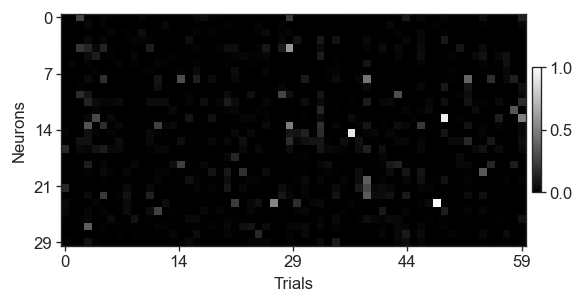

In [4]:
responses = normalize(data[2]["response"])

figure, ax = plt.subplots(
    nrows=1,
    ncols=1,
    gridspec_kw={"wspace": 0.05, "hspace": 0.01},
    figsize=(5, 5),
    dpi=120,
    facecolor="white",
)


N_TRIALS, N_NEURONS = 60, 30
ax.imshow(responses[:N_TRIALS, :N_NEURONS].T, cmap=GRAY)

x_ticks = np.linspace(0, N_TRIALS - 1, 5)
tensorboard.set_xticks(
    axis=ax, ticks_loc=x_ticks, ticks=x_ticks.astype(int), label="Trials"
)
y_ticks = np.linspace(0, N_NEURONS - 1, 5)
tensorboard.set_yticks(
    axis=ax, ticks_loc=y_ticks, ticks=y_ticks.astype(int), label="Neurons"
)

# add colorbar
width, height = 0.015, ax.get_position().y1 * 0.3
cbar_ax = figure.add_axes(
    rect=[
        ax.get_position().x1 + 0.01,
        ((ax.get_position().y1 - ax.get_position().y0) / 2 + ax.get_position().y0)
        - (height / 2),
        width,
        height,
    ]
)
figure.colorbar(cm.ScalarMappable(cmap=GRAY), cax=cbar_ax, shrink=0.1)
tensorboard.set_yticks(
    axis=cbar_ax,
    ticks_loc=np.linspace(0, 1, 3),
    ticks=np.linspace(0, 1, 3),
    label="",
)

plt.show()
plt.close(figure)

Plot image - response pairs from Mouse 3

In [15]:
images, responses = data[2]["image"], data[2]["response"]
print(f"image dimension: {images.shape[1:]}, number of neurons: {responses.shape[1]}")

image dimension: (1, 144, 256), number of neurons: 8372


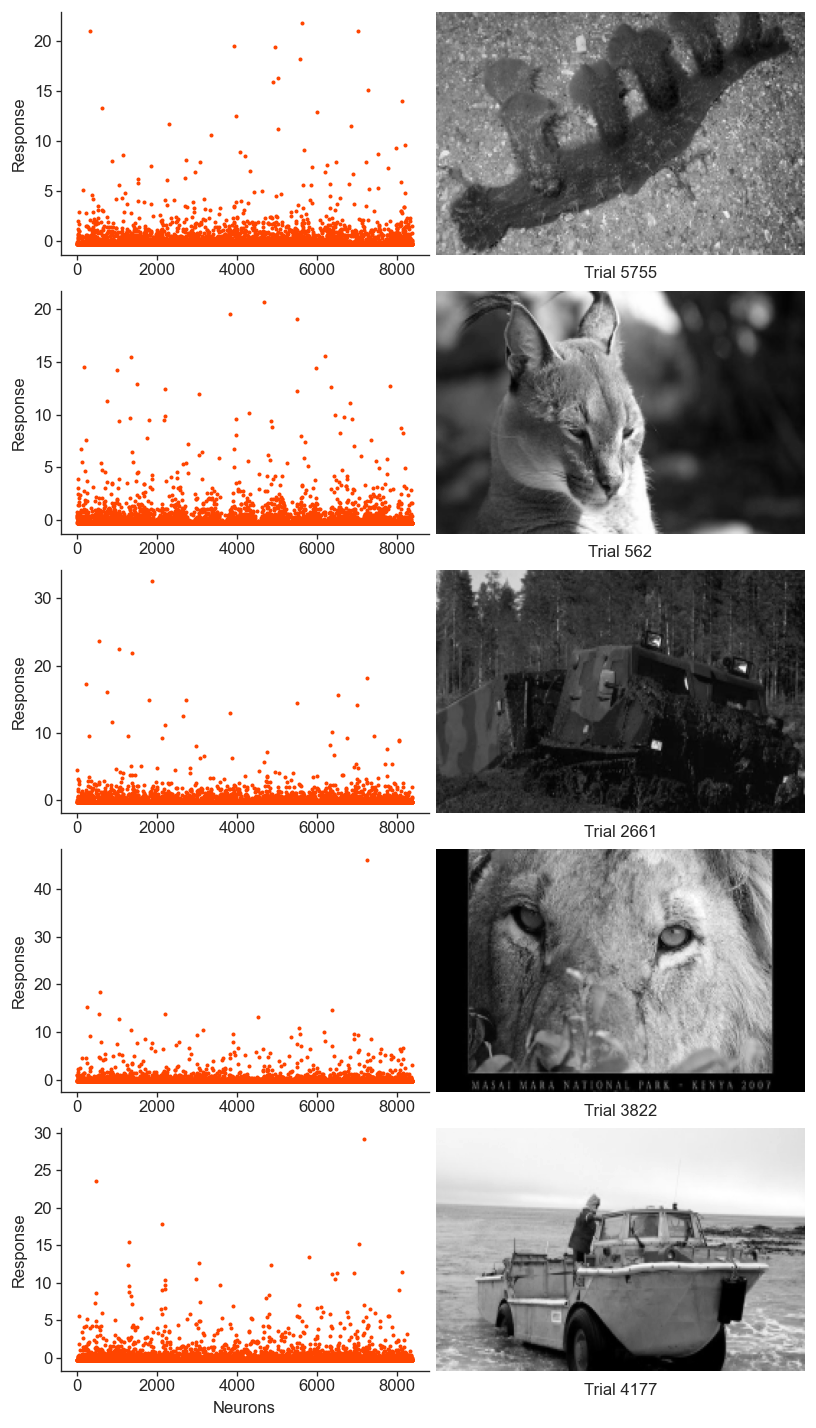

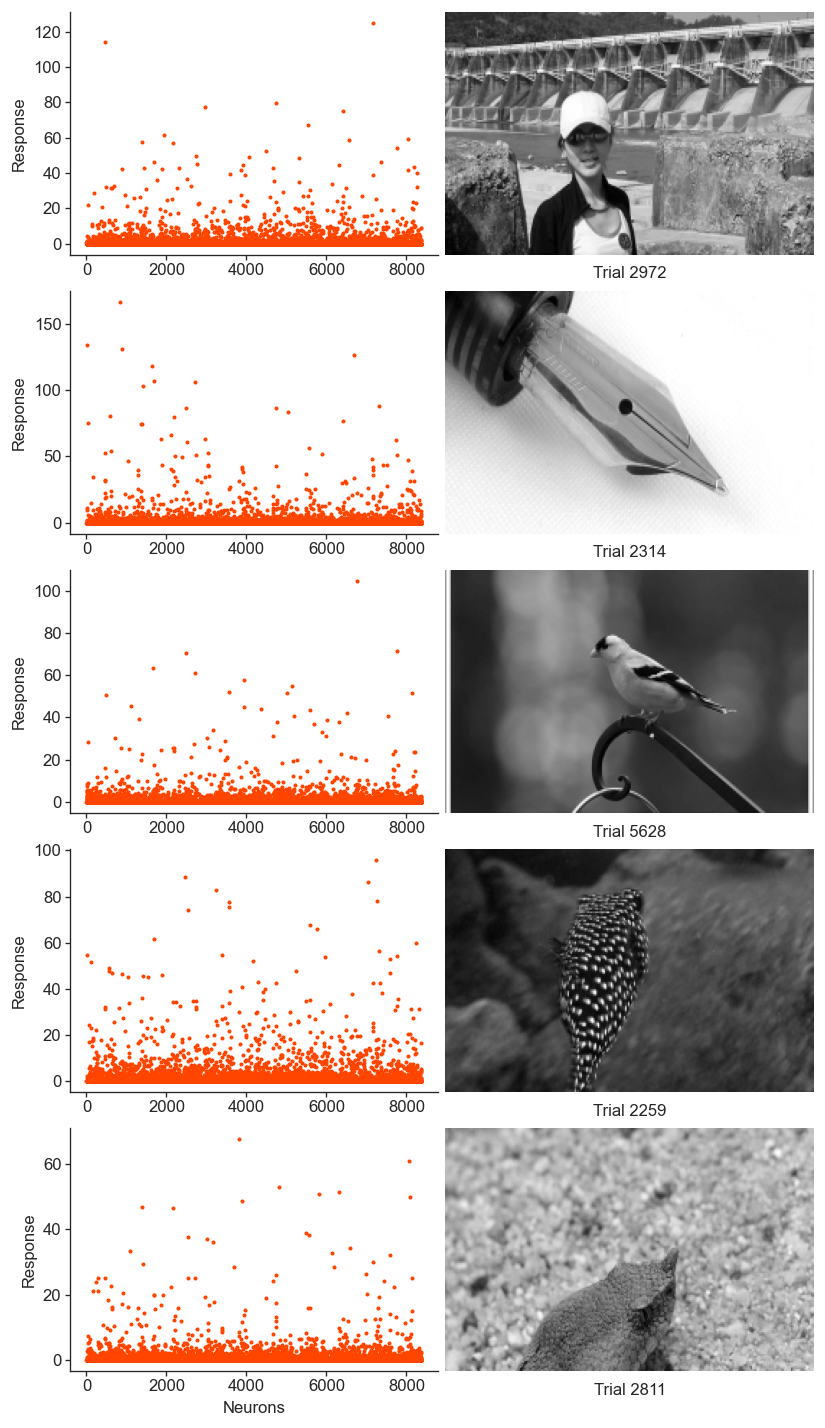

In [17]:
N_TRIALS = 5

figure, axes = plt.subplots(
    nrows=N_TRIALS,
    ncols=2,
    gridspec_kw={"wspace": 0.02, "hspace": 0.15},
    figsize=(8, 3 * N_TRIALS),
    dpi=120,
    facecolor="white",
)

trials = np.random.choice(images.shape[0], size=N_TRIALS, replace=False)
x_axis = np.arange(responses.shape[1])

for i, trial in enumerate(trials):
    axes[i, 0].scatter(x=x_axis, y=responses[trial], s=2, color="orangered")
    axes[i, 0].set_ylabel("Response")
    if i == N_TRIALS - 1:
        axes[i, 0].set_xlabel("Neurons")
    tensorboard.remove_top_right_spines(axis=axes[i, 0])
    axes[i, 1].imshow(normalize(images[trial][0]), cmap=GRAY, aspect="auto")
    axes[i, 1].set_xlabel(f"Trial {trial:03d}")
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    tensorboard.remove_spines(axis=axes[i, 1])

plt.show()
plt.close(figure)

Plot Mouse 3 - 7 response distributions

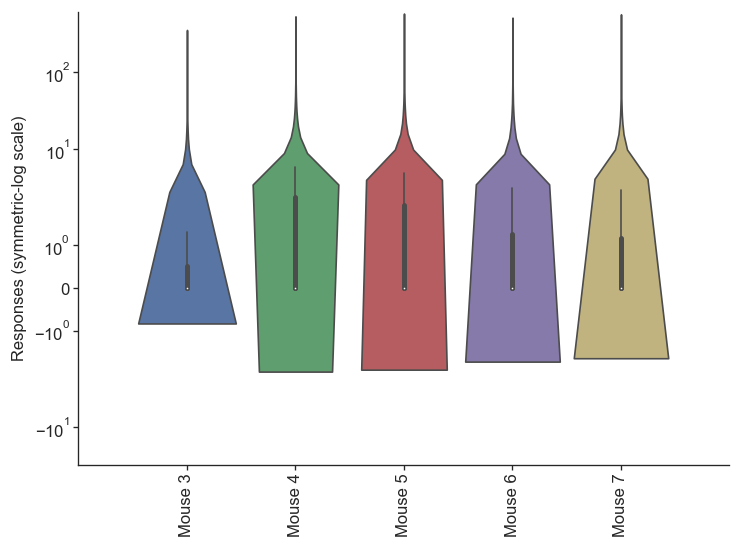

In [13]:
N_TRIALS = 100

figure, ax = plt.subplots(
    nrows=1,
    ncols=1,
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
    figsize=(7, 5),
    dpi=120,
    facecolor="white",
)

responses = [data[i]["response"][:N_TRIALS].flatten() for i in range(2, 7)]
sns.violinplot(
    data=responses, scale="count", width=0.9, inner="box", linewidth=1, ax=ax
)
ax.set_yscale("symlog")
ax.set_xticklabels(
    [f"Mouse {i+1}" for i in range(2, 7)], va="top", ha="center", rotation=90
)
ax.set_xlim(left=-1, right=len(responses))
tensorboard.remove_top_right_spines(axis=ax)
ax.set_ylabel("Responses (symmetric-log scale)")

plt.show()
plt.close(figure)